In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [76]:
#we first need to understand the data in the measurement table
md = sqlalchemy.MetaData()
MeasurementTable = sqlalchemy.Table('Measurement', md, autoload=True, autoload_with=engine)
MeasurementColumns = MeasurementTable.c
for c in MeasurementColumns:
    print(c.name, c.type)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [77]:
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [88]:
StationTable = sqlalchemy.Table('Station', md, autoload=True, autoload_with=engine)
StationColumns = StationTable.c
for c in StationColumns:
    print(c.name, c.type)

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [79]:
engine.execute("SELECT * FROM Station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [80]:
# 1. Design a query to retrieve the last 12 months of precipitation data and plot the results


In [81]:
# 1a. Calculate the date 1 year ago from the last data point in the database
MaxDate=session.query(func.max(Measurement.date)).first()
print(MaxDate)

('2017-08-23',)


In [82]:
# 1b. Calculate the date 1 year ago from the last data point in the database
YearDate=dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(YearDate)

2016-08-23


In [83]:
# 1c. Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

In [147]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df = pd.DataFrame(results)
precipmean_df = pd.DataFrame(precip.groupby(['date']).agg({'prcp':'mean'}))
precipmean_df.head()

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


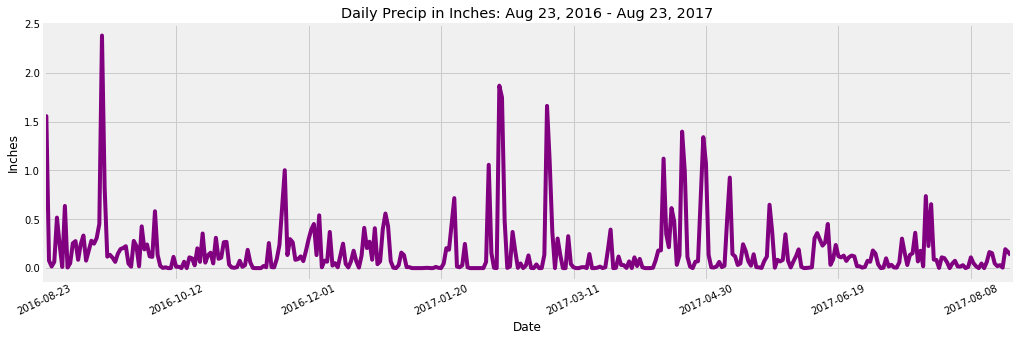

In [156]:
# Use Pandas Plotting with Matplotlib to plot the data
precipmean_df.plot(x_compat = True, figsize =(14, 5), rot = 90, color = "purple", legend = False)
plt.tight_layout()
plt.title("Daily Precip in Inches: Aug 23, 2016 - Aug 23, 2017")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=25)
plt.savefig("dailyprecipitation.png")
plt.show()

In [74]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [89]:
# Design a query to show how many stations are available in this dataset?
print("Total Station Count: "+ str(session.query(Station.station).count()))

Total Station Count: 9


In [97]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
StationsCount = session.query(Measurement.station, func.count(Measurement.tobs)).\
       group_by(Measurement.station).order_by(func.sum(Measurement.tobs).desc()).all()
labels = ['Station', 'Observations']
stationscount_df = pd.DataFrame.from_records(StationsCount, columns=labels)
stationscount_df


,Station,Observations
0,USC00519397,2724
1,USC00519523,2669
2,USC00519281,2772
3,USC00513117,2709
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [113]:
#Which station has the highest number of observations?
topstation = session.query(Station.name).filter(Station.station == stationscount_df['Station'][0]).all()
topstationid = str(stationscount_df['Station'][0])
print("The station with highest observation count is "+ 
      str(stationscount_df['Station'][0])+": "+ str(topstation[0]))


The station with highest observation count is USC00519397: ('WAIKIKI 717.2, HI US',)


In [121]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_temp = session.query(func.min(Measurement.tobs)).filter_by(station = topstationid).scalar()
max_temp = session.query(func.max(Measurement.tobs)).filter_by(station = topstationid).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter_by(station = topstationid).scalar()
print("For Station ID "+ str(topstationid)+": " +
      f'Min Temp is {min_temp}, Max Temp is {max_temp}, and Avg Tempis {avg_temp}')

For Station ID USC00519397: Min Temp is 56.0, Max Temp is 87.0, and Avg Tempis 74.55323054331865


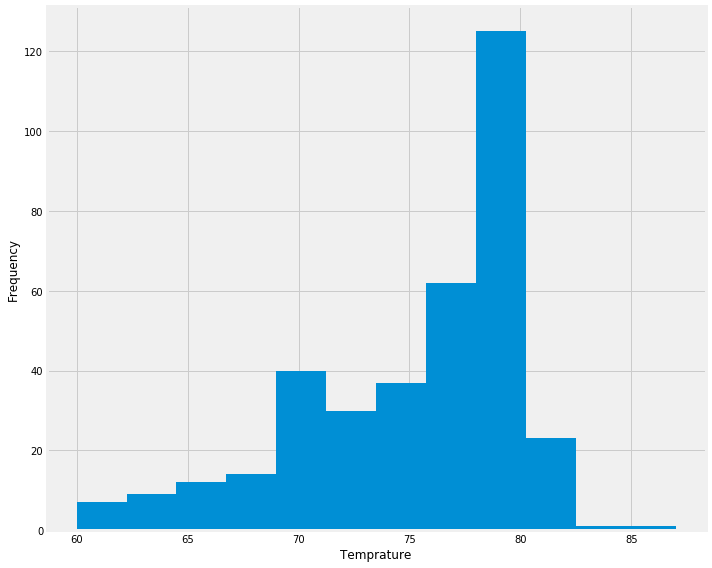

In [160]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_pd = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.date.between('2016-08-23', '2017-08-23'), Measurement.station == topstationid).all())
active_pd.plot.hist(bins=12, figsize=(10,8), legend = False)
plt.xlabel("Temprature")
plt.tight_layout()
plt.savefig("histogram.png")


# Temperature Analysis II

In [148]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    data = pd.DataFrame(session.query(Measurement.tobs).\
           filter(Measurement.date >= (pd.to_datetime(start_date)- dt.timedelta(days = 365)).strftime('%Y-%m-%d'),\
           Measurement.date < (pd.to_datetime(end_date)- dt.timedelta(days = 365)).strftime('%Y-%m-%d')).all())
    
    avg = round(data["tobs"].mean())
    low = data["tobs"].min()
    high = data["tobs"].max()
    
    print("Historical average temperature  for your vacation is: "+ str(avg) +" degrees")
    print("Historical low temperature for your vacation is: "+ str(low) +" degrees")
    print("Historical high temperature for your vacation is: "+ str(high) +" degrees")
    
    return avg, low, high

In [150]:
start_date = str(input("What is the first day of your vacation: "))
end_date = str(input("What is the last day of your vacation: "))
print()
print()
average, low, high = calc_temps(start_date, end_date)

What is the first day of your vacation: 2017-12-15
What is the last day of your vacation: 2017-12-31


Historical average temperature  for your vacation is: 72 degrees
Historical low temperature for your vacation is: 60.0 degrees
Historical high temperature for your vacation is: 78.0 degrees


In [153]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2018-08-06', '2018-08-15')

Historical average temperature  for your vacation is: 79 degrees
Historical low temperature for your vacation is: 71.0 degrees
Historical high temperature for your vacation is: 84.0 degrees


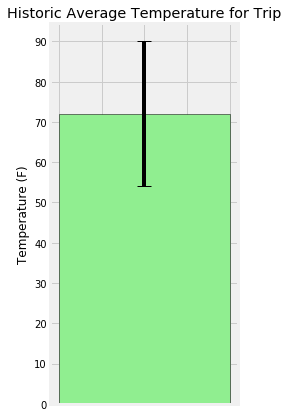

In [155]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize = (3,7))
ax.bar(1, average, color = 'lightgreen', edgecolor = 'black', yerr=(high - low), capsize = 7, label = 'test')
ax.set_xticklabels([])
plt.yticks(np.arange(0, average + 20, 10))
plt.title ("Historic Average Temperature for Trip")
plt.ylabel ("Temperature (F)")
plt.savefig("tripavgtemp.png")